<a href="https://colab.research.google.com/github/bbchen33/Insight-project/blob/master/Web_scrape_job_titles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping job titles from Indeed

In [0]:
from bs4 import BeautifulSoup
import requests

A list of job titles that I want to scrape from Indeed.

In [0]:
job_titles = 'accountant, bartender, chef, chief financial officer, civil engineer, editor, research assistant, marketing specialist, salesperson, software developer, software engineer, data scientist, volunteer, lawyer, graphic designer, ceo, it specialist, project manager, product manager, technical writer, journalist, medical doctor, pharmacist, translator, qa engineer, receptionist/ administrative assistant, recruiter, hr specialist, secretary, java developer, web developer, foreign language teacher, tour guide, president, mechanical engineer, electrical engineer, driver, professor, copywriter, intern, financial analyst, general manager, procurement specialist, sales manager, insurance agent, medical representative, credit officer, database developer, deputy manager, real estate agent, data entry clerk, ai engineer'

In [0]:
job_titles = job_titles.split(', ')

In [20]:
job_titles[:3]

['accountant', 'bartender', 'chef']

In [18]:
files.upload()

Saving indeed_search.PNG to indeed_search.PNG


{'indeed_search.PNG': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x83\x00\x00\x01J\x08\x06\x00\x00\x00\xa7\xef\x8a\xaf\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00W\xb2IDATx^\xed\xdd\t\xfc\\U}\xff\xff\xd4Z\xfe\xfd\xff\xdb\x7f\xf5Q\xd4\xf6Wk\xeb\xd6_[\xff?\x15\x17\xac\x0b\n\x82\x8a\n*\x8d\x82\xadU\xd9\x94]\x83,b\x95-!\xc6\x05P(\x14\x97\x12\x82H\x02.,A\xc0\x18\x91UBX$\x04\x02\x81ld!\x0b$\x10\xc8\xbe\x9f\xff\xfd\x9c{\xcf\x9ds\xce=w\x99\x99;\xf3\x9d\xef\xf7\xbe\x9e<>\xe4;w\xdf\xe6\xcey\xcf\xbd33J\x01\x00\n\xc8i\xb2\x93\x02\x00\x00\x18l\xb4X\x00\x8cp~H\x1b\xea2B\xfd\xda)\x00\x00\x80\xee\xd0\xa2@j\xdb\xf6\xed\xea\x85\xf5\x1b\xfaS\xeb\x02\xdd(\xaa\xe3\x1aE\x15Vh\x9bQ\x14EQ\x14\xd5\xf4"\x0cB\xdb\xbe}G\xf0\x00\xa1\xa8\xfa+\x14V(\xaaj\x85\x8e)\x8a\xa2(\x8a\xa2:)\xc2 \xd4\xce\x9d;\x83\x07\x07E\xd5_\xa1\xc6=E\xb5S\xa1\xe3\x8a\xa2(\x8a\xa2\xa8N\x8a08\xe0~<\xf1r\xf5?\x13\x7f\x92<

Below is what it looks like when you search for 'chief financial officer' jobs at Indeed. The url will turn the title into 'chief+financial+officer'.

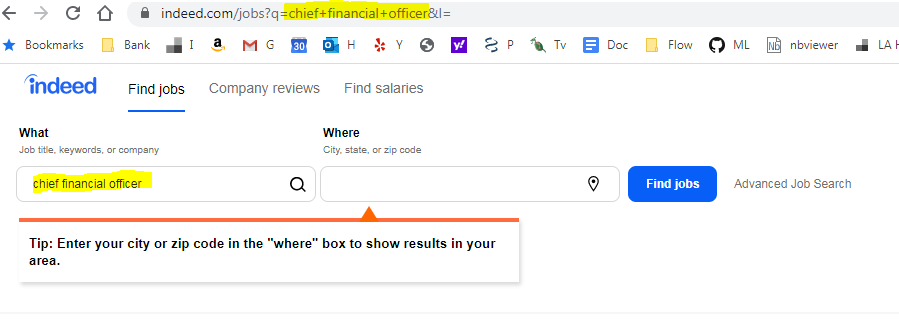

In [19]:
from IPython.display import Image
Image('indeed_search.PNG')

In [0]:
job_titles_for_scrape = []
for job in job_titles:
  text = job.split(' ')
  job_titles_for_scrape.append('+'.join(text))


In [23]:
job_titles_for_scrape[:5]

['accountant',
 'bartender',
 'chef',
 'chief+financial+officer',
 'civil+engineer']

Below shows an example of getting the scraped data and then I'll write function to automate the process.

In [0]:
source = requests.get(f'https://www.indeed.com/jobs?q=accountant&start=10').text
soup = BeautifulSoup(source, 'lxml')
soup_text = soup.get_text()

In [29]:
soup # jobmap is where the titles can be found

<!DOCTYPE html>
<html dir="ltr" lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<script src="/s/f37a6cf/en_US.js" type="text/javascript"></script>
<link href="/s/1ab3172/jobsearch_all.css" rel="stylesheet" type="text/css"/>
<link href="http://rss.indeed.com/rss?q=accountant" rel="alternate" title="Accountant Jobs, Employment" type="application/rss+xml"/>
<link href="/m/jobs?q=accountant" media="only screen and (max-width: 640px)" rel="alternate"/>
<link href="/m/jobs?q=accountant" media="handheld" rel="alternate"/>
<script type="text/javascript">

if (typeof window['closureReadyCallbacks'] == 'undefined') {
window['closureReadyCallbacks'] = [];
}

function call_when_jsall_loaded(cb) {
if (window['closureReady']) {
cb();
} else {
window['closureReadyCallbacks'].push(cb);
}
}
</script>
<meta content="1" name="ppstriptst"/>
<script>
var _scriptDownloadCount = 0;
var _retryDownload = function() {
var script = document.createElement('script');
var path 

Find index of 'jobmap' inside soup text.

In [0]:
import re
all_jobmap = [x.start() for x in re.finditer('jobmap', soup_text)]

Use the jobmap index to find the text and where the title occurs.

In [0]:
first_jobmap = soup_text[all_jobmap[0]:all_jobmap[0]+500]

Find where the keyword 'title' occurs.

In [36]:
first_jobmap.index('title')

264

Show where 'title' occurs and the next 100 characters following it.

In [38]:
first_jobmap[264:264+100]

"title:'Staff Accountant',locid:'2bea0353b2483fe2',rd:'KOZu4pedPCtcTJ9itYtMIKZM22n6iTqaU6nPqTLU8J-DBs"

Now anyone can see the title 'Staff Accountant' and can just split the text with ',' to discard the rest of the information.

In [0]:
import re
def get_titles(soup):
  soup_text = soup.get_text()
  all_jobmap = [x.start() for x in re.finditer('jobmap', soup_text)]
  jobmap_text = []
  for i in range(len(all_jobmap)):
    jobmap_text.append(soup_text[all_jobmap[i]:all_jobmap[i]+500]) #append start of jobmap and 500 more characters after its occurence
  title_index = []
  for titles in jobmap_text:
    try:
      title_index.append(titles.index('title')) #append index where the word 'title' occurs
    except:
      pass
  job_titles = []

  for x,y in zip(title_index, jobmap_text):
    job_title = y[x:x+100]
    job_title = job_title.split(',')[0] #remove the rest of the characters after ','
    job_title = job_title.replace('title:','') 
    job_title = job_title[1:-1]
    job_titles.append(job_title)
  return job_titles

In [0]:
job_dict = {}
for job in job_titles_for_scrape:
  for i in range(10, 70, 10): # start with 10 (page 2), ends with 70 (page 6) see next line
    source = requests.get(f'https://www.indeed.com/jobs?q={job}&start={i}').text #start= is for page number, page 1 is none, page 2 is 10, page 3 is 20 and so on 
    soup = BeautifulSoup(source, 'lxml')
    if job not in job_dict:
      job_dict[job] = get_titles(soup)
    else:
      job_dict[job] += get_titles(soup)

In [41]:
len(job_dict)

52

In [42]:
job_dict['accountant']

['Staff Accountant',
 'Staff Accountant',
 'Trust Operations Accountant',
 'Accountant',
 'Accountant',
 'Staff Accountant',
 'Senior Accountant - minimum 5 years experience required',
 'Staff Accountant',
 'Accountant',
 'Systems Accountant',
 'Senior Accountant',
 'Accountant - ||| (INFOR or Lawson)',
 'Treasury Accountant',
 'Accountant',
 'Senior Accountant',
 'Accountant I',
 'Financial Accountant (GLIM required)',
 'Senior Accountant',
 'Staff Accountant (accounting degree req)',
 'Staff Accountant (accounting degree req) (Dyersbur',
 'Accountant',
 'Accountant',
 'Staff Accountant',
 'Staff Accountant',
 'Trust Operations Accountant',
 'Staff Accountant (accounting degree req)',
 'Staff Accountant',
 'Accountant - ||| (INFOR or Lawson)',
 'Senior Accountant',
 'Junior Accountant',
 'Trust Accountant',
 'Senior Accountant',
 'Financial Accountant (GLIM required)',
 'Accountant',
 'Staff Accountant',
 'Sr. Staff Accountant',
 'Associate Accountant - Maritz Motivation',
 'Accountan

The length of job_dict is the number of job titles I want to scrape. It's 52 so it is correct.

Next, let's make the dictionary into a dataframe. First, we'll need to combine all of the scraped job titles into a list.

In [0]:
collected_job = []
for jobs in job_dict.values():
  for job in jobs:
    collected_job.append(job)

In [45]:
len(collected_job)

6111

In [0]:
import pandas as pd
indeed_df = pd.DataFrame()
indeed_df['various job'] = collected_job

In [0]:
import itertools
official_jobs = []
for job in job_titles_for_scrape:
  for x in itertools.repeat(job, len(job_dict[job])):
    official_jobs.append(x)

In [0]:
indeed_df['official_job'] = official_jobs

In [51]:
indeed_df.head()

,various job,official_job
0,Staff Accountant,accountant
1,Staff Accountant,accountant
2,Trust Operations Accountant,accountant
3,Accountant,accountant
4,Accountant,accountant


In [0]:
indeed_df.to_csv('indeed_jobs.txt', sep = '\t', index = False)